In [1]:
import pandas as pd

In [2]:
def true_range(df): 
    '''
    df must be a pandas dataframe with high low and close column
    return a pandas series
    '''
    df['_tr1'] = df.high - df.low
    df['_tr2']  = (df.high - df.close.shift(1)).abs()
    df['_tr3']  = (df.low - df.close.shift(1)).abs()
    true_range = df[['_tr1','_tr2','_tr3']].max(axis=1)
    df.drop(df.columns[df.columns.str.startswith('_')], axis=1, inplace=True)
    return  true_range

In [3]:
def average_true_range(tr,n):
    '''
    tr is a pandas series
    return a pandas series
    '''
    return tr.ewm(com=n-1,adjust=False).mean()

In [4]:
def directional_movement(df):
    '''
    df must be a pandas dataframe with high low column
    return a tuple of pandas series up and down directional movement
    '''
    up_dm = df.high - df.high.shift(1)
    down_dm = df.low.shift(1) - df.low
    up_dm.mask(up_dm < 0,0,inplace=True)
    down_dm.mask(down_dm < 0,0,inplace=True)
    up_dm.mask(up_dm < down_dm,0,inplace=True)
    down_dm.mask(down_dm < up_dm, 0,inplace=True)
   
    return up_dm, down_dm

In [5]:
def average_directional_movement_index(df,n):
    '''
    df must be a pandas dataframe with high low  and close column
    return a tuple of pandas series adxr = the strength of a price movement
    '''
    up_dm, down_dm = directional_movement(df)
    tr = true_range(df)    
 
    up_DMn = up_dm.ewm(com=n-1,adjust=False).mean()
    
    down_DMn = down_dm.ewm(com=n-1,adjust=False).mean()
    TRn = tr.ewm(com=n-1,adjust=False).mean()
    up_DI = up_DMn/TRn
    down_DI = down_DMn/TRn

    DX = abs(up_DI- down_DI)/(up_DI + down_DI)
   
    ADX = DX.ewm(com=n-1,adjust=False).mean()
    ADXR = (ADX + ADX.shift(n-1)) / 2
    
    return ADXR

In [6]:
def rsi(close,n):
    '''
    close is a pandas series
    n is the period for smooth in exponential means
    return a pandas series as rsi
    '''
    
    delta = close - close.shift(1) 
    delta = delta.dropna()
    
    closeup = delta.mask(delta < 0, 0)
    closedown = delta.mask(delta > 0,0).abs()
    

    closeup[closeup.index[n-1]]= closeup[:n].mean()
    closeup = closeup.drop(closeup.index[:n-1])
    avg_closeup = closeup.ewm(com=n-1,adjust=False).mean() 

    closedown[closedown.index[n-1]]= closedown[:n].mean()
    closedown = closedown.drop(closedown.index[:n-1])
    avg_closedown = closedown.ewm(com=n-1,adjust=False).mean()

    rsi = avg_closeup / (avg_closedown + avg_closeup)

    return rsi

In [7]:
min_period = 300
N = 14
df = pd.read_csv(f"data/USDT_BTC_{min_period}_1425168000_73.csv")
df.rename(columns={'date':'epoch','ts':'date'},inplace=True)
assert df.loc[0,'period'] == min_period, "Error, period different from min_period"
assert df['period'].count() == df.shape[0], "Error, period not always is min_period" 
df.drop(columns=['period','currency_pair','quoteVolume','weightedAverage'],inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by="date") #just in case
df.set_index('date',inplace=True)
df

,epoch,high,low,open,close,volume
date,,,,,,
2015-03-01 00:00:00,1425168000,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:05:00,1425168300,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:10:00,1425168600,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:15:00,1425168900,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:20:00,1425169200,240.000060,240.000060,240.000060,240.000060,0.000000
...,...,...,...,...,...,...
2021-03-31 23:35:00,1617233700,58802.587059,58761.857003,58801.000000,58762.000000,29415.195318
2021-03-31 23:40:00,1617234000,58798.268464,58744.683295,58762.000000,58795.050899,169054.589184
2021-03-31 23:45:00,1617234300,58866.551166,58795.050899,58795.050899,58810.585631,4315.762275


In [18]:
df['body'] = (df.close - df.open).abs()/(df.high - df.low) 
df['up_tail'] = (df.high - df[['close','open']].max(axis=1)) /(df.high - df.low) 
df['low_tail'] = (df[['close','open']].min(axis=1) - df.low) /(df.high - df.low) 
df['roc0'] = (df.close/df.open) - 1.0
df['roc1'] = df.close.pct_change(periods=1)
df['roc3'] = df.close.pct_change(periods=3)
df['roc7'] = df.close.pct_change(periods=7)
df['roc14'] = df.close.pct_change(periods=14)
df['roc28'] = df.close.pct_change(periods=28)
df['velocity'] = (df.close - df.open)/(df.epoch - df.epoch.shift(1))
df['avg_price'] = (df.close + df.open + df.high + df.low) / 4.0
df['base_volume'] = df.volume * df.avg_price
df['momentum'] = df.velocity * df.base_volume
df['real_momentum'] = df.momentum * df.body
df['sma50'] = df.close.rolling(50).mean()
df['delta_sma50'] = df.close - df.sma50
df['ema20'] = df.close.ewm(span=20).mean() 
df['delta_ema20'] = df.close - df.ema20
df['macd'] =  df.close.ewm(span=13).mean() - df.close.ewm(span=26).mean()
df['adxr'] = average_directional_movement_index(df,N)
df['rsi'] = rsi(df.close,N)

df.dropna(inplace=True)

df['macd_z'] = (df.macd - df.macd.rolling(200).mean())/df.macd.rolling(200).std()
df['ema20_z'] = (df.delta_ema20 - df.delta_ema20.rolling(200).mean())/df.delta_ema20.rolling(200).std()
df['sma50_z'] = (df.delta_sma50 - df.delta_sma50.rolling(200).mean())/df.delta_sma50.rolling(200).std()


In [19]:
df

,epoch,high,low,open,close,volume,body,up_tail,low_tail,roc0,...,avg_price_day,base_volume_day,momentum_day,real_momentum_day,adxr_day,rsi_day,delta_sma50,delta_ema20,ema20_z,sma50_z
date,,,,,,,,,,,,,,,,,,,,,
2015-08-24 02:30:00,1440383400,233.125548,233.000000,233.125548,233.000000,37.390033,1.000000,0.000000,0.000000,-5.385434e-04,...,208.429442,6.487748e+05,1.787777e+02,77.215880,0.287462,0.354713,1.781400,0.689791,NaN,NaN
2015-08-24 03:55:00,1440388500,235.870004,232.660925,232.660925,235.870004,120.921317,1.000000,0.000000,0.000000,1.379294e-02,...,208.429442,6.487748e+05,1.787777e+02,77.215880,0.287462,0.354713,4.314004,3.220767,NaN,NaN
2015-08-24 05:55:00,1440395700,229.000001,229.000001,229.000001,229.000001,82.337138,1.000000,0.000000,0.000000,-4.366818e-11,...,208.429442,6.487748e+05,1.787777e+02,77.215880,0.287462,0.354713,-2.453653,-3.301690,NaN,NaN
2015-08-24 06:00:00,1440396000,229.000001,228.000000,229.000001,228.000000,5.043432,1.000000,0.000000,0.000000,-4.366816e-03,...,208.429442,6.487748e+05,1.787777e+02,77.215880,0.287462,0.354713,-3.333654,-3.892006,NaN,NaN
2015-08-24 06:05:00,1440396300,226.438599,225.000000,226.438599,225.000000,334.514167,1.000000,0.000000,0.000000,-6.353152e-03,...,208.429442,6.487748e+05,1.787777e+02,77.215880,0.287462,0.354713,-6.050642,-6.235625,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 23:35:00,1617233700,58802.587059,58761.857003,58801.000000,58762.000000,29415.195318,0.957524,0.038965,0.003511,-6.632540e-04,...,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062,-76.919529,-5.368225,0.042897,-0.128634
2021-03-31 23:40:00,1617234000,58798.268464,58744.683295,58762.000000,58795.050899,169054.589184,0.616792,0.060046,0.323162,5.624536e-04,...,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062,-32.060172,25.046229,0.153934,-0.031698
2021-03-31 23:45:00,1617234300,58866.551166,58795.050899,58795.050899,58810.585631,4315.762275,0.217268,0.782732,0.000000,2.642184e-04,...,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062,-14.106286,36.716107,0.199194,0.011468


In [20]:
df.ema20_z.describe()


count    490487.000000
mean         -0.001630
std           1.086355
min         -12.393745
25%          -0.573009
50%           0.015080
75%           0.586364
max          12.937200
Name: ema20_z, dtype: float64

<AxesSubplot:>

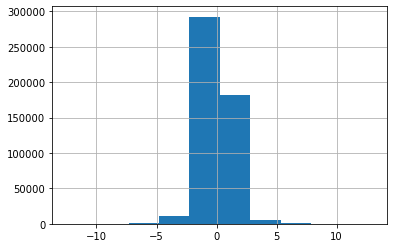

In [21]:
df.ema20_z.hist()

In [11]:
daily_df = df.resample('D').agg({'epoch':'first','high':'max','low':'min','open':'first','close':'last','volume':'sum'})

In [12]:
df['body_day'] = (daily_df.close - daily_df.open).abs()/(daily_df.high - daily_df.low) 
df['up_tail_day'] = (daily_df.high - daily_df[['close','open']].max(axis=1)) /(daily_df.high - daily_df.low) 
df['low_tail_day'] = (daily_df[['close','open']].min(axis=1) - daily_df.low) /(daily_df.high - daily_df.low) 
df['roc0_day'] = (daily_df.close/daily_df.open) - 1.0
df['velocity_day'] = (daily_df.close - daily_df.open)/(daily_df.epoch - daily_df.epoch.shift(1))
df['avg_price_day'] = (daily_df.close + daily_df.open + daily_df.high + daily_df.low) / 4.0
df['base_volume_day'] = daily_df.volume * df.avg_price_day
df['momentum_day'] = df.velocity_day *  df.base_volume_day
df['real_momentum_day'] = df.momentum_day * df.body_day
df['adxr_day'] = average_directional_movement_index(daily_df,N)
df['rsi_day'] = rsi(daily_df.close,N)

In [13]:
df.fillna(method='ffill',inplace=True)
df

,epoch,high,low,open,close,volume,body,up_tail,low_tail,roc0,...,up_tail_day,low_tail_day,roc0_day,velocity_day,avg_price_day,base_volume_day,momentum_day,real_momentum_day,adxr_day,rsi_day
date,,,,,,,,,,,,,,,,,,,,,
2015-04-11 08:45:00,1428741900,236.780000,236.515000,236.515000,236.765000,5.846007,9.433962e-01,0.056604,0.000000,1.057015e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-11 08:50:00,1428742200,236.785000,236.285033,236.785000,236.350000,5.766044,8.700580e-01,0.000000,0.129942,-1.837110e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-11 08:55:00,1428742500,236.790000,236.365000,236.365000,236.785000,5.611421,9.882353e-01,0.011765,0.000000,1.776913e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-11 09:00:00,1428742800,243.092517,236.550000,236.550000,243.092517,5.011934,1.000000e+00,0.000000,0.000000,2.765807e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-11 09:05:00,1428743100,243.092517,236.285033,243.092517,243.092517,5.583605,1.468973e-09,0.000000,1.000000,-4.113665e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 23:35:00,1617233700,58802.587059,58761.857003,58801.000000,58762.000000,29415.195318,9.575238e-01,0.038965,0.003511,-6.632540e-04,...,0.352352,0.64606,-0.000079,-0.000054,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062
2021-03-31 23:40:00,1617234000,58798.268464,58744.683295,58762.000000,58795.050899,169054.589184,6.167919e-01,0.060046,0.323162,5.624536e-04,...,0.352352,0.64606,-0.000079,-0.000054,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062
2021-03-31 23:45:00,1617234300,58866.551166,58795.050899,58795.050899,58810.585631,4315.762275,2.172682e-01,0.782732,0.000000,2.642184e-04,...,0.352352,0.64606,-0.000079,-0.000054,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062
